# [原文](https://zh.d2l.ai/chapter_attention-mechanisms/index.html)

# 注意力机制

> 注意力机制的神经网络架构设计.

## 生物学上的注意力提示

> 非自主性提示: 报纸,论文,咖啡,笔记本,书 (假设纸制品都是黑的,咖啡是红的), 注意力会不由自主的引导到红色的咖啡杯子.<br>
> 自主性提示: 加入意志线索(想读书)后,注意力被引导到书上.

## 注意力机制架构

> 非自主性提示的实现:参数化的全连接层,甚至是非参数化的max pooling 或者 average pooling.<br>
> <font color=green>是否包含自主性提示</font>将注意力机制与全连接层或汇聚层区别开来.<br>

<center>nn.Linear 完成了如下操作:</center>
$$\rm y = x A^T + b$$
$$\rm [*, out\_features] = [*, in\_features] @ [out\_features, in\_features]^{ \boldsymbol{T} } + b$$
<center><img src=../Linear/imgs/Linear.png /></center>



* query, key, value<br>
> 每个值都与一个键（key）配对， 这可以想象为感官输入的非自主提示<br>
> 注意力汇聚: 可以通过设计注意力汇聚的方式， 便于给定的查询（自主性提示）与键（非自主性提示）进行匹配， 这将引导得出最匹配的值（感官输入）

![](./imgs/qkv.svg)

## 一: 注意力汇聚

> <font color=green>注意力汇聚相当于键的加权平均,输入多少键,输出多少值.只是加大了某些权重,减少了某些权重</font>

In [7]:
import torch

In [9]:
import d2l.torch as d2l

In [9]:
torch.__version__

'1.13.1+cu117'

In [3]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, size=(n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [4]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

### 平均汇聚

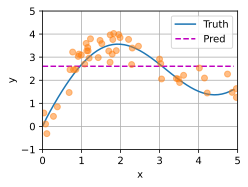

In [5]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

### 非参数注意力汇聚

* 非参数注意力汇聚之nw回归.

$$\rm f(x) = \sum_{i=1}^{n} \frac{K(x-x_i)}{\sum_{j=1}^n K(x-x_j)} y_i$$

* 更通用的attention pooling 公式:

$$\rm f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i$$

> * 使用高斯核
> $$\rm K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2})  $$ <br>
> 
>
>
$$
\begin{aligned}
\rm f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\
& = \rm \sum_{i=1}^{n} \frac{\exp \left(-\frac{1}{2} (x-x_i)^2 \right)  }{ \sum_{j=1}^{n}  \exp \left(-\frac{1}{2} (x-x_i)^2 \right)    } y_i \\
& = \rm \sum_{i=1}^{n}    softmax \left(  -\frac{1}{2} (x-x_i)^2 \right) y_i \\
\end{aligned}
$$

> softmax函数在x趋向负无穷的时候值无限趋近于0.<font color=green>越近权重越高,越远权重越低,这是平方(正负距离都行)和softmax共同实现的</font><br>
> 所以这样一来就保留了键和查询之间的差距足够小的pair($x-x_i$)，过滤掉了键和值差距较大的pair($x-x_i$)，<br>
> 从而达到注意力效果，使得预测结果更加准确。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def max_x(x, delta=0.):
    x = np.array(x)
    negative_idx = x < delta
    x[negative_idx] = 0.
    return x
x = np.array(range(-10, 10))
s_j = np.array(x)

hinge_loss = max_x(s_j, delta=1.)

# plt.plot(s_j, hinge_loss)
# plt.title("Max Function")

Text(0.5, 1.0, 'softmax vs Max')

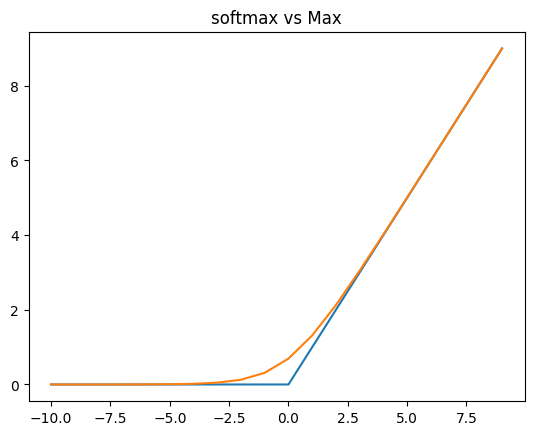

In [3]:
def cross_entropy_test(s_k, s_j=0):
    soft_max = 1/(1+np.exp(s_k - s_j))
    cross_entropy_loss = -np.log(soft_max)
    return cross_entropy_loss
s_i = 0
s_k = np.array(range(-10, 10))

soft_x = cross_entropy_test(s_k, s_i)

plt.plot(x, hinge_loss)
plt.plot(range(-10, 10), soft_x)
plt.title("softmax vs Max")

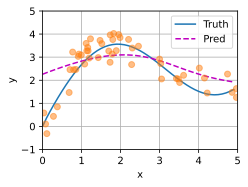

In [6]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

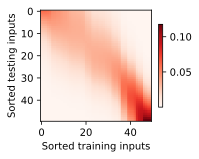

In [7]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [ ]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),                                                                                                            
                  cmap='Reds'):
    """Show heatmaps of matrices.

    Defined in :numref:`sec_attention-cues`"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(d2l.numpy(matrix), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

$$\rm f(x) = \sum_{i=1}^{n} softmax \left( -\frac{1}{2} (x-x_i)^2 \right) y_i$$

<font color=red>请你实现一下这个注意力汇聚</font>

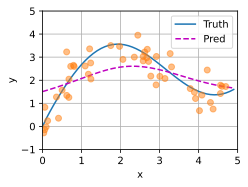

In [8]:
X_repeat = x_test.repeat_interleave(x_test.shape[0]).reshape(-1, n_train)
y = torch.softmax(-0.5 * ((X_repeat - x_train) ** 2), dim=1) @ y_train
plot_kernel_reg(y)

In [9]:
weight = torch.softmax(-0.5 * ((X_repeat - x_train) ** 2), dim=1)
weight

tensor([[6.0522e-02, 6.0457e-02, 6.0443e-02,  ..., 1.8444e-06, 1.5478e-06,
         9.7954e-07],
        [5.6999e-02, 5.7080e-02, 5.7089e-02,  ..., 2.7322e-06, 2.3018e-06,
         1.4711e-06],
        [5.3511e-02, 5.3720e-02, 5.3751e-02,  ..., 4.0348e-06, 3.4121e-06,
         2.2023e-06],
        ...,
        [1.3911e-06, 1.5623e-06, 1.5916e-06,  ..., 7.4689e-02, 7.5034e-02,
         7.5419e-02],
        [9.3342e-07, 1.0509e-06, 1.0710e-06,  ..., 7.8833e-02, 7.9500e-02,
         8.0699e-02],
        [6.2396e-07, 7.0427e-07, 7.1803e-07,  ..., 8.2892e-02, 8.3914e-02,
         8.6022e-02]])

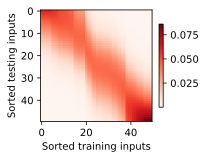

In [10]:
d2l.show_heatmaps(weight.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

$$\rm f(x) = \sum_{i=1}^{n} softmax \left( -\frac{1}{2} (x-x_i)^2 \right) y_i$$
> 每一个$x$(预测结果)都与所有的$x_i$(训练样本)都有关, $x$与$x_i$差值作为<font color=green>注意力权重(离得越远权重越低)</font>, 然后与每一个$y_i$相乘后相加得到一个$\hat{y}$<br>
> 雨露均沾: 预测结果$\hat{y}$ 对每一个训练$y$, 根据$x$(待预测因变量)与$x_i$(训练样本)形成注意力权重,从每一个$y_i$都拿一点点, 近的多拿,远的少拿

### 带参数注意力汇聚

* bmm小批量矩阵乘法计算小批量数据中的加权平均值

In [11]:
import torch

In [12]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape(2, 10)
weights.shape
values.shape

torch.Size([2, 10])

torch.Size([2, 10])

In [13]:
weights[0].sum()

tensor(1.0000)

In [14]:
weights.sum(dim=1)

tensor([1.0000, 1.0000])

In [15]:
# [2, 1, 10] @ [2, 10, 1] = [2, 1, 1]

In [16]:
torch.matmul(weights.unsqueeze(1), values.unsqueeze(2))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [17]:
weights.unsqueeze(1) @ values.unsqueeze(-1)

tensor([[[ 4.5000]],

        [[14.5000]]])

$$\rm f(x) = \sum_{i=1}^{n} softmax \left( -\frac{1}{2} \big((x-x_i)w \big)^2 \right) y_i$$

> <font color=red>请实现此模型^</font>

In [18]:
# 前向传播

In [19]:
x_train

tensor([0.0308, 0.0557, 0.0597, 0.0931, 0.1302, 0.3560, 0.4087, 0.5011, 0.6172,
        0.6201, 0.6739, 0.6756, 0.7211, 0.7931, 0.8103, 1.0931, 1.1743, 1.2062,
        1.2330, 1.2388, 1.7476, 1.9736, 2.0594, 2.3516, 2.4418, 2.5789, 2.5791,
        2.6169, 2.6701, 2.6845, 2.7169, 2.7742, 2.9101, 2.9183, 3.0062, 3.1375,
        3.2706, 3.3059, 3.7851, 3.8923, 3.9203, 4.0213, 4.0847, 4.2210, 4.3037,
        4.3718, 4.5592, 4.5605, 4.5988, 4.6972])

In [20]:
# 每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
X_tile

tensor([[0.0308, 0.0557, 0.0597,  ..., 4.5605, 4.5988, 4.6972],
        [0.0308, 0.0557, 0.0597,  ..., 4.5605, 4.5988, 4.6972],
        [0.0308, 0.0557, 0.0597,  ..., 4.5605, 4.5988, 4.6972],
        ...,
        [0.0308, 0.0557, 0.0597,  ..., 4.5605, 4.5988, 4.6972],
        [0.0308, 0.0557, 0.0597,  ..., 4.5605, 4.5988, 4.6972],
        [0.0308, 0.0557, 0.0597,  ..., 4.5605, 4.5988, 4.6972]])

In [21]:
# 每一行都包含着相同的训练输出
y_tile = y_train.repeat((n_train, 1))
y_tile

tensor([[-0.2818, -0.1452,  0.8267,  ...,  1.7847,  1.7357,  1.7274],
        [-0.2818, -0.1452,  0.8267,  ...,  1.7847,  1.7357,  1.7274],
        [-0.2818, -0.1452,  0.8267,  ...,  1.7847,  1.7357,  1.7274],
        ...,
        [-0.2818, -0.1452,  0.8267,  ...,  1.7847,  1.7357,  1.7274],
        [-0.2818, -0.1452,  0.8267,  ...,  1.7847,  1.7357,  1.7274],
        [-0.2818, -0.1452,  0.8267,  ...,  1.7847,  1.7357,  1.7274]])

In [22]:
X_tile.shape
y_tile.shape

torch.Size([50, 50])

torch.Size([50, 50])

In [23]:
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
keys
keys.shape

tensor([[0.0557, 0.0597, 0.0931,  ..., 4.5605, 4.5988, 4.6972],
        [0.0308, 0.0597, 0.0931,  ..., 4.5605, 4.5988, 4.6972],
        [0.0308, 0.0557, 0.0931,  ..., 4.5605, 4.5988, 4.6972],
        ...,
        [0.0308, 0.0557, 0.0597,  ..., 4.5592, 4.5988, 4.6972],
        [0.0308, 0.0557, 0.0597,  ..., 4.5592, 4.5605, 4.6972],
        [0.0308, 0.0557, 0.0597,  ..., 4.5592, 4.5605, 4.5988]])

torch.Size([50, 49])

In [24]:
# 每一行都包含着相同的训练输出
values = y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values
values.shape

tensor([[-0.1452,  0.8267, -0.0231,  ...,  1.7847,  1.7357,  1.7274],
        [-0.2818,  0.8267, -0.0231,  ...,  1.7847,  1.7357,  1.7274],
        [-0.2818, -0.1452, -0.0231,  ...,  1.7847,  1.7357,  1.7274],
        ...,
        [-0.2818, -0.1452,  0.8267,  ...,  1.4239,  1.7357,  1.7274],
        [-0.2818, -0.1452,  0.8267,  ...,  1.4239,  1.7847,  1.7274],
        [-0.2818, -0.1452,  0.8267,  ...,  1.4239,  1.7847,  1.7357]])

torch.Size([50, 49])

$$\rm f(x) = \sum_{i=1}^{n} softmax \left( -\frac{1}{2} \big((x-x_i)w \big)^2 \right) y_i$$

In [25]:
queries = x_train

In [26]:
queries.shape

torch.Size([50])

In [27]:
queries

tensor([0.0308, 0.0557, 0.0597, 0.0931, 0.1302, 0.3560, 0.4087, 0.5011, 0.6172,
        0.6201, 0.6739, 0.6756, 0.7211, 0.7931, 0.8103, 1.0931, 1.1743, 1.2062,
        1.2330, 1.2388, 1.7476, 1.9736, 2.0594, 2.3516, 2.4418, 2.5789, 2.5791,
        2.6169, 2.6701, 2.6845, 2.7169, 2.7742, 2.9101, 2.9183, 3.0062, 3.1375,
        3.2706, 3.3059, 3.7851, 3.8923, 3.9203, 4.0213, 4.0847, 4.2210, 4.3037,
        4.3718, 4.5592, 4.5605, 4.5988, 4.6972])

In [28]:
keys

tensor([[0.0557, 0.0597, 0.0931,  ..., 4.5605, 4.5988, 4.6972],
        [0.0308, 0.0597, 0.0931,  ..., 4.5605, 4.5988, 4.6972],
        [0.0308, 0.0557, 0.0931,  ..., 4.5605, 4.5988, 4.6972],
        ...,
        [0.0308, 0.0557, 0.0597,  ..., 4.5592, 4.5988, 4.6972],
        [0.0308, 0.0557, 0.0597,  ..., 4.5592, 4.5605, 4.6972],
        [0.0308, 0.0557, 0.0597,  ..., 4.5592, 4.5605, 4.5988]])

In [29]:
keys.shape
values.shape

torch.Size([50, 49])

torch.Size([50, 49])

In [30]:
queries.shape

torch.Size([50])

In [31]:
queries = queries.repeat_interleave(keys.shape[1]).reshape(-1, keys.shape[1])
queries
queries.shape

tensor([[0.0308, 0.0308, 0.0308,  ..., 0.0308, 0.0308, 0.0308],
        [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
        [0.0597, 0.0597, 0.0597,  ..., 0.0597, 0.0597, 0.0597],
        ...,
        [4.5605, 4.5605, 4.5605,  ..., 4.5605, 4.5605, 4.5605],
        [4.5988, 4.5988, 4.5988,  ..., 4.5988, 4.5988, 4.5988],
        [4.6972, 4.6972, 4.6972,  ..., 4.6972, 4.6972, 4.6972]])

torch.Size([50, 49])

$$\rm f(x) = \sum_{i=1}^{n} softmax \left( -\frac{1}{2} \big((x-x_i)w \big)^2 \right) y_i$$

In [32]:
w = torch.nn.Parameter(data=torch.rand((1,)), requires_grad=True)

In [33]:
attention_weights = torch.softmax((-0.5 * ((queries - keys) * w) ** 2), dim=-1) 
attention_weights

tensor([[0.0503, 0.0503, 0.0503,  ..., 0.0002, 0.0002, 0.0001],
        [0.0497, 0.0497, 0.0497,  ..., 0.0002, 0.0002, 0.0002],
        [0.0496, 0.0496, 0.0496,  ..., 0.0002, 0.0002, 0.0002],
        ...,
        [0.0002, 0.0002, 0.0002,  ..., 0.0558, 0.0558, 0.0555],
        [0.0002, 0.0002, 0.0002,  ..., 0.0569, 0.0569, 0.0568],
        [0.0002, 0.0002, 0.0002,  ..., 0.0598, 0.0598, 0.0599]],
       grad_fn=<SoftmaxBackward0>)

In [34]:
attention_weights.shape
values.shape

torch.Size([50, 49])

torch.Size([50, 49])

* 输出肯定也是 [50, 49]
* [50, 1, 49] @ [50, 29, 1]

In [35]:
attention_weights.unsqueeze(1).shape
attention_weights.unsqueeze(1)

torch.Size([50, 1, 49])

tensor([[[0.0503, 0.0503, 0.0503,  ..., 0.0002, 0.0002, 0.0001]],

        [[0.0497, 0.0497, 0.0497,  ..., 0.0002, 0.0002, 0.0002]],

        [[0.0496, 0.0496, 0.0496,  ..., 0.0002, 0.0002, 0.0002]],

        ...,

        [[0.0002, 0.0002, 0.0002,  ..., 0.0558, 0.0558, 0.0555]],

        [[0.0002, 0.0002, 0.0002,  ..., 0.0569, 0.0569, 0.0568]],

        [[0.0002, 0.0002, 0.0002,  ..., 0.0598, 0.0598, 0.0599]]],
       grad_fn=<UnsqueezeBackward0>)

In [36]:
values.unsqueeze(-1).shape
values.unsqueeze(-1)

torch.Size([50, 49, 1])

tensor([[[-0.1452],
         [ 0.8267],
         [-0.0231],
         ...,
         [ 1.7847],
         [ 1.7357],
         [ 1.7274]],

        [[-0.2818],
         [ 0.8267],
         [-0.0231],
         ...,
         [ 1.7847],
         [ 1.7357],
         [ 1.7274]],

        [[-0.2818],
         [-0.1452],
         [-0.0231],
         ...,
         [ 1.7847],
         [ 1.7357],
         [ 1.7274]],

        ...,

        [[-0.2818],
         [-0.1452],
         [ 0.8267],
         ...,
         [ 1.4239],
         [ 1.7357],
         [ 1.7274]],

        [[-0.2818],
         [-0.1452],
         [ 0.8267],
         ...,
         [ 1.4239],
         [ 1.7847],
         [ 1.7274]],

        [[-0.2818],
         [-0.1452],
         [ 0.8267],
         ...,
         [ 1.4239],
         [ 1.7847],
         [ 1.7357]]])

In [37]:
w

Parameter containing:
tensor([0.7327], requires_grad=True)

In [38]:
attention_weights.unsqueeze(1) @ values.unsqueeze(-1)

tensor([[[1.8561]],

        [[1.8574]],

        [[1.8105]],

        [[1.8639]],

        [[1.8636]],

        [[1.8979]],

        [[1.9573]],

        [[1.9400]],

        [[1.9171]],

        [[1.9944]],

        [[2.0180]],

        [[1.9872]],

        [[1.9827]],

        [[2.0087]],

        [[2.0171]],

        [[2.1205]],

        [[2.1616]],

        [[2.1331]],

        [[2.1639]],

        [[2.1907]],

        [[2.2826]],

        [[2.3255]],

        [[2.3561]],

        [[2.3741]],

        [[2.3428]],

        [[2.3701]],

        [[2.3766]],

        [[2.3614]],

        [[2.3661]],

        [[2.3523]],

        [[2.3675]],

        [[2.3837]],

        [[2.3798]],

        [[2.3357]],

        [[2.3520]],

        [[2.3314]],

        [[2.2640]],

        [[2.2771]],

        [[2.1901]],

        [[2.1671]],

        [[2.1711]],

        [[2.1667]],

        [[2.1194]],

        [[2.0301]],

        [[2.0753]],

        [[2.0720]],

        [[1.9886]],

        [[1.9

In [39]:
(attention_weights.unsqueeze(1) @ values.unsqueeze(-1)).reshape(-1)
(attention_weights.unsqueeze(1) @ values.unsqueeze(-1)).reshape(-1).shape

tensor([1.8561, 1.8574, 1.8105, 1.8639, 1.8636, 1.8979, 1.9573, 1.9400, 1.9171,
        1.9944, 2.0180, 1.9872, 1.9827, 2.0087, 2.0171, 2.1205, 2.1616, 2.1331,
        2.1639, 2.1907, 2.2826, 2.3255, 2.3561, 2.3741, 2.3428, 2.3701, 2.3766,
        2.3614, 2.3661, 2.3523, 2.3675, 2.3837, 2.3798, 2.3357, 2.3520, 2.3314,
        2.2640, 2.2771, 2.1901, 2.1671, 2.1711, 2.1667, 2.1194, 2.0301, 2.0753,
        2.0720, 1.9886, 1.9681, 1.9608, 1.9358],
       grad_fn=<ReshapeAliasBackward0>)

torch.Size([50])

### 带参数注意力汇聚-深度模型求解参数

In [1]:
import torch
import torch.nn as nn
import d2l.torch as d2l

In [2]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, size=(n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

$$\rm f(x) = \sum_{i=1}^{n} softmax \left( -\frac{1}{2} \big((x-x_i)w \big)^2 \right) y_i$$

* 训练求解$w$的时候,query=key=x_train. 预测的时候使用的是x_test

In [5]:
class NWKernelRegression(nn.Module):
    
    def __init__(self):
        super(NWKernelRegression, self).__init__()
        self.w = nn.Parameter(torch.rand((1,)), requires_grad=True)
        
    def forward(self, queries, keys, values):
        # queries:[[q0,q0,q0,q0,q0,q0,q0,q0,q0]
        #         [q1,q1,q1,q1,q1,q1,q1,q1,q1]] = [50, 49]
        # keys: [[q0, q1, q2,...qn]
        #        [q0, q1, q2,...qn]] = [50, 49]
        # # 查询 x的每一个值与键 x的每一个值.求注意力权重
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        
        # queies keys 都是基于训练数据得到的. q0与除子集以外的所有q_i  计算注意力权重 shape都是[50, 49]
        # -0.5 * ((queries - keys) * self.w) ** 2 是注意力评分函数
        # 查询 x的每一个值与键 x的每一个值.求注意力权重
        self.attention_weights = torch.softmax(-0.5 * ((queries - keys) * self.w) ** 2, dim=1)
        
        values_hat = (self.attention_weights.unsqueeze(1) @ values.unsqueeze(-1)).reshape(-1)
        return values_hat

In [5]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

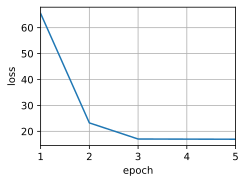

In [6]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])


for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

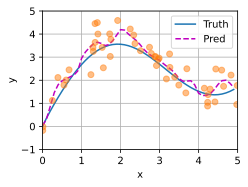

In [7]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

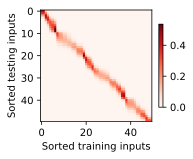

In [8]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [9]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile
# values的形状:('n_train'，'n_train'-1)
values = Y_tile

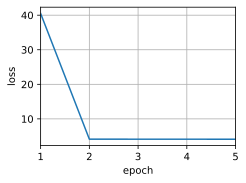

In [10]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])


for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

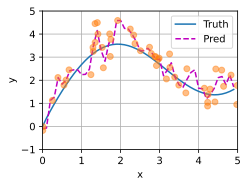

In [11]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

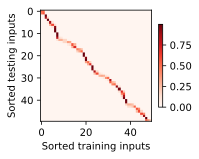

In [12]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

* 如何将超参数添加到非参数的Nadaraya-Watson核回归中以实现更好地预测结果:
> 们知道softmax函数在x趋向负无穷的时候值无限趋近于0，所以这样一来就保留了键和查询之间的差距足够小的pair，过滤掉了键和值差距较大的pair，<br>
> 从而达到注意力效果，使得预测结果更加准确。

* 在带参数的注意力汇聚的实验中学习得到的参数$\rm w$的价值是什么？

> 拟合更好了, 给训练过程一个参数.比传统的统计方法要好一些.

为什么在**可视化注意力权重(热力图)**时，它会使加权区域更加尖锐？
>
>因为注意力更集中在附近的几个点 <br>
> 如何将超参数添加到非参数的Nadaraya-Watson核回归中以实现更好地预测结果:<br>
> 们知道softmax函数在x趋向负无穷的时候值无限趋近于0，所以这样一来就保留了键和查询之间的差距足够小的pair($x-x_i$)，过滤掉了键和值差距较大的pair($x-x_i$)，<br>
> 从而达到注意力效果，使得预测结果更加准确。

<font color=green>注意力都是词级别的</font>
> 无论是ESIM中的注意力<br>
> 还是本例中的x(查询$\rm x$的每一个值与键$\rm x_i$的每一个值.求注意力权重 ), 都是x级别的.  不是句子级别, 不是embedding级别.

* 非参数注意力汇聚之nw回归.

$$\rm f(x) = \sum_{i=1}^{n} \frac{K(x-x_i)}{\sum_{j=1}^n K(x-x_j)} y_i$$

* 更通用的attention pooling 公式:

$$\rm f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i$$

> * 使用高斯核
> $$\rm K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2})  $$ <br>
> 注意力评分函数 attention scoring function:<br>
> $$\begin{aligned} &= \rm -\frac{u^2}{2} \\ & = -\frac{(x-x_i)^2}{2} \\ \end{aligned}$$ 
>
>
$$
\begin{aligned}
\rm  f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\
& = \rm \sum_{i=1}^{n} \frac{\exp \left(-\frac{1}{2} (x-x_i)^2 \right)  }{ \sum_{j=1}^{n}  \exp \left(-\frac{1}{2} (x-x_i)^2 \right)    } y_i \\
& = \rm \sum_{i=1}^{n}    softmax \left(  -\frac{1}{2} (x-x_i)^2 \right) y_i \\
\end{aligned}
$$

> softmax函数在x趋向负无穷的时候值无限趋近于0.<font color=green>越近权重越高,越远权重越低,这是平方(正负距离都行)和softmax共同实现的</font><br>
> 所以这样一来就保留了键和查询之间的差距足够小的pair($x-x_i$)，过滤掉了键和值差距较大的pair($x-x_i$)，<br>
> 从而达到注意力效果，使得预测结果更加准确。

## 二: 注意力评分函数

> 1. 评分函数: 高斯核的指数部分<br>
> 2. 输入到softmax,得到查询$x$与值的概率分布.(查询与键对比得到权重)<br>
> 3. 注意力汇聚的输出: 每个$x$都得到一个$\hat y$:<font color=green>所有$y$的加权和.</font>


![](./imgs/attention-output.svg)

> 用数学语言描述,假设有一个查询$\rm q \in \mathbb{R^q}$ 和 $\rm m$个键值对$\rm (k_1, v_1), \cdots, (k_m, v_m)$, 其中$\rm k_i \in \mathbb{R}^k, v_i \in \mathbb{R}^v $ 都是<font color=green>向量, 且键的维度和值的维度是各自相同的</font><br>
> <font color=green>注意力汇聚**函数**f</font>:就被表示成值的加权和. <br>
> $$\rm f(q, (k_1, v_1), \cdots, (k_m, v_m)) = \sum_{i=1}^{m} \alpha (q, k_i) v_i ~ \in \mathbb{R}^v$$
> 其中查询$\rm q$和键$\rm k_i$(<font color=green>标量,所以结果标量</font>)的注意力权重(<font color=green>标量</font>)如下:<br>
> $$\rm \alpha(q, k_i) = softmax(a(q, k_i)) = \frac{exp(a(q, k_i))}{\sum_{j=1}^{m} exp(a(q, k_j)) } ~ \in \mathbb{R}       $$ 
> 是通过注意力评分函数$a$将两个向量映射成标量,再经过softmax运算得到的.<br>

> - $\rm q, k , v 的维度都是1$, 就是上面的模型 NWKernelRegression,这个模型里并没有向量运算,都是<font color=green>标量</font>的, 只不过加了批量运算.<br>
>> ```
>> def forward(self, queries, keys, values):
>>         # queries:[[q0,q0,q0,q0,q0,q0,q0,q0,q0]
>>         #         [q1,q1,q1,q1,q1,q1,q1,q1,q1]] = [50, 49]
>>         # keys: [[q0, q1, q2,...qn]
>>         #        [q0, q1, q2,...qn]] = [50, 49]
>>         # # 查询 x的每一个值与键 x的每一个值.求注意力权重
>>         queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
>>         
>>         # 查询 x的每一个值与键 x的每一个值.求注意力权重
>>         self.attention_weights = torch.softmax(-0.5 * ((queries - keys) * self.w) ** 2, dim=1)
>>         
>>         values_hat = (self.attention_weights.unsqueeze(1) @ values.unsqueeze(-1)).reshape(-1)
>>         return values_hat
>> ```
>> 注意哦: 训练求参数w时,query=key=x_train
>> ||$\rm k_0$|$\rm k_1$|$\rm k_2$|$\rm k_3$||
>> |---|---|---|---|---|---|
>> |$\rm q_0$|score0|score1|score2|score3|\|step1:score0 = $q_0 - k_i$<font color=green>标量</font>|
>> |$\rm q_1$|||||\|step2:score0-score4 进过softmax变成p0-p3, p0+p1+p2+p3=1|
>> |$\rm q_2$|||||\|step3:喜_hat = 爱embeding\*p0 + 打embedding\*p1 + 篮embedding\*p2 + 球embedding\*p3|
>> |$\rm q_3$|||||\|即：喜_hat = 喜 与 '爱打篮球‘每个词的相似度的加权平均|
>> |$\rm q_4$|||||\|key point： 注意力机制是词粒度的, 注意力要实现的是语义对齐。（跟词的embedding无关)|
> - $\rm q, k , v$都是<font color=green>向量</font>的比如ESIM模型<br>
>> $$\rm e_{ij} = {\overline p_i}^T {\overline q}_j$$
>> 
>> 
>> ||爱|打|篮|球||
>> |---|---|---|---|---|---|
>> |喜|score0|score1|score2|score3|\|step1:score0 = 喜的embedding<font color=green>向量</font> 与 爱的embedding内积(内积=相似度=未归一化的余弦相似度)|
>> |欢|||||\|step2:score0-score4 进过softmax变成p0-p3, p0+p1+p2+p3=1|
>> |打|||||\|step3:喜_hat = 爱embeding\*p0 + 打embedding\*p1 + 篮embedding\*p2 + 球embedding\*p3|
>> |篮|||||\|即：喜_hat = 喜 与 '爱打篮球‘每个词的相似度的加权平均|
>> |球|||||\|key point： 注意力机制是词粒度的, 注意力要实现的是语义对齐。（跟词的embedding无关)|
>> 
>> 
>> $$\rm {\overline  p}_i  = \sum_{j=1}^{l_q}  \frac{exp(e_{ij})}{\sum_{k=1}^{l_q} exp(e_{ij})} {\overline q}_j, \forall_i \in [1, \cdots, l_p]$$<br>
>> $$\rm {\overline  q}_i = \sum_{j=1}^{l_p}  \frac{exp(e_{ij})}{\sum_{k=1}^{l_p} exp(e_{ij})} {\overline p}_i, \forall_i \in [1, \cdots, l_q]$$<br>

<font color=green>注意力都是词级别的</font>
> 无论是ESIM中的注意力<br>
> 还是本例中的x(查询$\rm x$的每一个值与键$\rm x_i$的每一个值.求注意力权重 ), 都是x级别的.  不是句子级别, 不是embedding级别.


### 加性注意力

> masked softmax operation

In [1]:
import torch

In [2]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences.
    Defined in :numref:`sec_seq2seq_decoder`"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

In [3]:
def masked_softmax(X, valid_lens):
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2397, 0.4233, 0.3370, 0.0000]],

        [[0.4601, 0.5399, 0.0000, 0.0000],
         [0.2423, 0.2593, 0.2181, 0.2803]]])

In [5]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4679, 0.5321, 0.0000, 0.0000],
         [0.3895, 0.6105, 0.0000, 0.0000]],

        [[0.4968, 0.2693, 0.2338, 0.0000],
         [0.4043, 0.1736, 0.4221, 0.0000]]])

> 用数学语言描述,假设有一个查询$\rm q \in \mathbb{R^q}$ 和 $\rm m$个键值对$\rm (k_1, v_1), \cdots, (k_m, v_m)$, 其中$\rm k_i \in \mathbb{R}^k, v_i \in \mathbb{R}^v $ 都是<font color=green>向量, 且键的维度和值的维度是各自相同的</font><br>
> <font color=green>注意力汇聚函数f</font>:就被表示成值的加权和. <br>
> $$\rm f(q, (k_1, v_1), \cdots, (k_m, v_m)) = \sum_{i=1}^{m} \alpha (q, k_i) v_i ~ \in \mathbb{R}^v$$
> 其中查询$\rm q$和键$\rm k_i$(<font color=green>标量,所以结果标量</font>)的注意力权重(<font color=green>标量</font>)如下:<br>
> $$\rm \alpha(q, k_i) = softmax(a(q, k_i)) = \frac{exp(a(q, k_i))}{\sum_{j=1}^{m} exp(a(q, k_j)) } ~ \in \mathbb{R}       $$ 
> 是通过<font color=green>注意力评分函数$a$</font>将两个向量映射成标量,再经过softmax运算得到的.<br>

> 当查询和键是不同长度的矢量时，可以使用加性注意力作为评分函数 <br>
> <font color=green>加性注意力评分函数</font><br>
> $$\rm a(\mathbf{q}, \mathbf{k}) = w_v^T \tanh (W_qq + W_k k) ~ \in \mathbb{R}$$

In [15]:
keys = torch.ones((2, 10, 2))
keys.shape

torch.Size([2, 10, 2])

In [16]:
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
values.shape

torch.Size([2, 10, 4])

In [17]:
queries = torch.normal(0, 1, (2, 1, 20))
queries.shape

torch.Size([2, 1, 20])

> <font color=red>请实现一下加性注意力, additive attention</font><br>
>>

> <font color=red>快速说出nn.Linear.weights</font>, Linear input.shape, output.shape,<br>
>> [答案](../Linear/Linear_case.ipynb)

> <font color=red>为什么要升维?</font>,查询、键和值的形状为（批量大小，步数或词元序列长度，特征大小）<br>
>> 演示升维原因(下面的代码): (每一个)query要与每一个key进行比较(广义的比较包括:无论是之前提到的高斯核,还是后面的缩放点积)<br>

> <font color=red>如何升维呢</font><br>
>> q = [batch_size, 查询个数, 特征大小] + k=[batch_size, 键的个数, 特征大小]<br>
>> 升维: q = [batch_size, 查询个数, 1, 特征大小] + k=[batch_size, 1, 键的个数, 特征大小]<br>
>> 广播: q+k = [batch_size, 查询个数, 键的个数, 特征大小]<br>

> <font color=red>最终输出为何要降维?</font><br>
> 因为注意力汇聚最终要输出一个<font color=green>标量 $\rm \in R$</font>, 所以最后的仿射变换 $\rm out\_features=1$<br>
>> w * q+k = [batch_size, 查询个数, 键的个数, 特征大小] = [batch_size, 查询个数, 键的个数, 1]<br>
>> 降维:[batch_size, 查询个数, 键的维度]<br>
>> 查询 与 键的维度[标量,标量,标量....] 完成dim=-1的softmax  求出<font color=green>注意力权重</font><br>
>> 权重$\times$值 得到 查询经过注意力汇聚后的结果: [batch_size, 查询个数, 值的特征大小]


In [14]:
q = torch.ones((2, 1, 1, 8))
q
# 将[1., 1., 1., 1., 1., 1., 1., 1.] 重复 (键的数量) 次,才能使查询与每个键都进行比较

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1.]]]])

In [15]:
k = torch.zeros((2, 1, 10, 8))
k

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

In [18]:
s = q + k
s.shape
s

torch.Size([2, 1, 10, 8])

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.]]]])

<font color=red>请说明这里为什么没有位置信息</font>

In [20]:
class AdditiveAttention(nn.Module):
    
    def __init__(self, key_size=2, query_size=20, num_hiddens=100, dropout=0.1, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        # weight = [num_hiddens, key_size] * queries = [ key_size, 1] = out.shape [num_hiddens, 1] 
        self.W_k = nn.Linear(in_features=key_size, out_features=num_hiddens, bias=False)
        self.W_q = nn.Linear(in_features=query_size, out_features=num_hiddens, bias=False)
        self.W_v = nn.Linear(in_features=num_hiddens, out_features=1, bias=False)
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        # values.shape = [2, 1, 20]
        # queries.shape = [2, 1, 20] 
        # keys.shape = [2, 10, 2] 
        queries =  self.W_q(queries)
        keys = self.W_k(keys)
        
        features = (keys.unsqueeze(1) + queries.unsqueeze(2))
        # queries.shape  [2, 1, 1, num_hiddens] = [batch_size, 查询个数(查询的每一个值), 1, num_hiddens]
        # keys.shape [2, 1, 10, num_hiddens] = [batch_size, 1, k-v个数, num_hiddens]
        # features.shape = [2, 1, 10, num_hiddens]
        features = torch.tanh(features)
        scores = self.W_v(features).squeeze(-1)
        #scores.shape = [2, 1, 10] = [batch_size, 查询个数,键值对个数]
        self.attention_weights = masked_softmax(scores, valid_lens)
        # attention_weights.shape = []
        
        return torch.bmm(self.dropout(self.attention_weights), values)

In [21]:
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
values.shape

torch.Size([2, 10, 4])

In [22]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
v_hat = attention(queries, keys, values, valid_lens)
v_hat
v_hat.shape

AdditiveAttention(
  (W_k): Linear(in_features=2, out_features=8, bias=False)
  (W_q): Linear(in_features=20, out_features=8, bias=False)
  (W_v): Linear(in_features=8, out_features=1, bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

torch.Size([2, 1, 4])

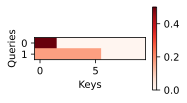

In [20]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

### 缩放点积注意力

> 点积操作需要queries和keys具有相同的长度$d$<br>
> 假设queries和keys的所有元素都是独立的随机变量.<font color=green>且满足均值为0,方差为1</font><br>
> 那么<font color=red>两个向量的点积的均值为0, 方差为$d$</font><br>
> 为确保无论向量长度如何,<font color=green>点积的方差</font>在不考虑向量长度的情况下仍然是$1$,我们再将点积除以$\sqrt{d}$<br>
> 则缩放点积注意力(scaled dot-product attention)<font color=green>评分函数为</font>:
> $$\rm a(q, k) =  \frac{q^Tk}{\sqrt{d}}$$
> 实践中,我们常基于小批量的角度提高效率<br>
> <font color=green>点积缩放注意力</font>:<br>
> <center>其中查询和键的长度为$d$, 值的长度为$v$<center><br>
> $$\rm softmax \left(\frac{QK^T}{\sqrt{d}} \right) V ~ \in ~ \mathbb{R}^{n \times v}$$  <br>
> $$\rm Q \in \mathbb{R}^{n \times d}$$<br>
> $$\rm K \in \mathbb{R}^{m \times d}$$<br>
> $$\rm V \in \mathbb{R}^{m \times v}$$<br>
> 
>

<font color=red>请说明这里为什么没有位置信息</font>

In [21]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [22]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

DotProductAttention(
  (dropout): Dropout(p=0.5, inplace=False)
)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

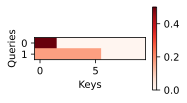

In [23]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

<font color=red><a href='https://zhuanlan.zhihu.com/p/380892265'>attention机制详解-要读哦</a></font>

## Bahdanau注意力

> 基于RNN的seq2seq模型,选择编码器最后一个hidden_state作为context与解码器的embedding作为解码器的输入.<br>
>> Bahdanau是这个人提出来的,将加性注意力用于改进基于RNN的机器翻译的效果.<br>
>> 编码器的每个词的输出作为key和value(既key和value是一样的), **解码器**<font color=green>对上一个词的输出是query(没办法其实应该是当前词,但还没生成, 只能与上一个词的输出把附近信息query出来)</font><br>
>> <font color=red>之所以不用解码器当前词的embedding,是因为 解码器上一个词的输出作为query, 和编码器的各个时刻$t$,RNN的输出大体在一个语义空间</font><br>
>> 注意力输出(与输入shape一致(除了最后一个dim))和解码器的下一个词embedding<font color=green>合并</font>进入下一层.<br>
>> 不同时刻$t$用不同的1,2,3,4的加权.query 不同.<br>
>> <font color=green>采用加性注意力是因为加性注意力有可学习的参数,即使等长, 也不使用点积注意力</font>


> 注意力机制可以根据解码器RNN的输出,匹配到合适编码器RNN的输出, 可以更有效的传递信息.




![](./imgs/seq2seq-attention-details.svg)

<font color=red> 请实现一下基于bahdanau的seq2seq模型</font>

## 多头注意力

> <font color=red>多头注意力与自注意力不是绑定的</font>
> - 对同一key，value，query，希望抽取不同的信息(<font color=green>不同 ”子空间表示 representation subspaces)</font> <br>
>>  捕获序列内各种范围的依赖关系 （例如，有的<font color=green>注意力</font>捕获短距依赖和有的捕获长距离依赖关系）类似卷积的多通道，但你的dimension其实已经是多通道了，

> 多头注意力使用$h$个独立的注意力池化<br>
> 最后将这<font color=green>h个注意力汇聚</font>的输出<font color=green>拼接</font>在一起，并且通过另一个可学习的<font color=green>线性投影</font>进行变换， 以产生最终输出。<br>
> 这种设计被称为 <font color=green>多头注意力</font>

![](./imgs/multi-head-attention.svg)

> 给定查询$\rm q \in \mathbb{R}^{d_q}$, 键$\rm k \in \mathbb{R}^{d_k}$和值$\rm v \in \mathbb{R}^{d_v}$, 每一个<font color=green>注意力头$\rm h_i (i=1, \cdots, h)$输出</font>：<br>
> $$\rm h_i = f\left(W_i^{(q)}q,  W_i^{(k)}k, W_i^{(v)}v       \right) \in \mathbb{R}^{pv}$$

> <font color=red>$i$可学习参数的形状</font><br>
> $\rm W_i^{(q)} \in \mathbb{R}^{p_q \times d_q} $<br>
> $\rm W_i^{(k)} \in \mathbb{R}^{p_k \times d_k} $<br>
> $\rm W_i^{(v)} \in \mathbb{R}^{p_v \times d_v} $<br>
> 以及代表注意力汇聚的函数$f$。$f$可以是<font color=green>加性注意力和缩放点积注意力</font>.<br>
> <font color=red>请写出汇聚后的形状</font><br>
> 多头注意力的输出需要经过另一个线性变换，它对应着$h$个头连结后的结果， <font color=green>输出的可学习参数</font>$\rm W_o \in \mathbb{R}^{(p_o \times hp_v)}$<br>
> 多头注意力的输出<br>
> $W_o\left[
\begin{matrix}
h_1 \\
h_2  \\
\vdots  \\
h_h  
\end{matrix}
\right] \in \mathbb{R}^{P_o}
$


> <font color=red>本实现的设定:</font><br>
> $\rm p_q = p_k = p_v = p_o/h_o$, <br>
> 值的注意的是如果将queries，keys，values的线性变换的输出数量设置为$\rm p_qh = p_k h = p_v h= p_o$, 则可并行计算$h$个头。在下面的实现中，$\rm p_o$是通过参数$\rm num\_hiddens$指定的。

In [2]:
import math
import torch
import torch.nn as nn
from d2l import torch as d2l

In [8]:
def transpose_qkv(X, num_heads):
    """为多头注意力的并行计算而变换形状:n个头都要投影，为了不做n次投影，然后再切回来"""
    # 输入X的形状:(batch_size, 查询或键值对的个数，num_hiddens
    # 输出X的形状:(batch_size, 查询或键值对的个数，num_heads, num_hiddens/num_heads)
    # 首先把你最后的维度， 切成4个维度， [0, 1, num_heads, num_hiddens/num_heads]
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    
    # 输出X的形状：(batch_size, num_heads, 查询或键值对的个数, num_hiddens/num_heads)
    # 其次，num_headswei和查询和键的个数或者seq_len 调换
    X = X.permute(0, 2, 1, 3)
    
    # 最终输出形状：(batch_size*num_heads, 查询或键的个数， num_hiddens/num_heads)
    # 再次，将batch_size和num_heads合并
    return X.reshape(-1, X.shape[2], X.shape[3])

In [9]:
def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

<font color=red>请仔细分析一下维度变化</font>

In [43]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        # DotProductAttention无参数, 相对简单
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        
    def forward(self, queries, keys, values, valid_lens):
        # queries，keys， values .shape = [batch_size, 查询或者`键值对`的个数， num_hiddens]
        # valid_lens 的形状:
        # (batch_size, ) 或 (batch_size, 查询的个数)
        # 经过变换后，输出的queries，keys，values的形状：
        # (batch_size * num_heads, 查询或键的个数, num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        
        if valid_lens is not None:
            # 在轴0， 将第一项（标量或矢量)复制num_heads次.
            # 然后如此复制第二项，然后注入此类
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
        # output的形状：(batch_size*num_heads, 查询的个数, num_hiddens/num_heads)
        # transpose_qkv把batch_size和num_heads合并到一起，编程一个3D的tensor，可以直接扔进Attention
        output = self.attention(queries, keys, values, valid_lens)
        
        # output_concat的形状：(batch_size, 查询的个数, num_hiddens)
        # 再转为4维
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

> 多头注意力的输出形状为(batch_size, num_queries, num_hiddens)

In [11]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [12]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens = 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

> 多头注意力融合了来自多个注意力汇聚的不同知识，这些知识的不同来源于相同的查询，键，值的不同的<font color=green>子空间表示</font><br>
> 基于适当的张量操作，可以实现多头注意力的并行计算。

![](./imgs/multi_head_code_parse.png)

## 自注意力和位置编码

### 定义

> - 给定序列$\rm x_1, \cdots, x_n, \forall x_i \in \mathbb{R}^d$<br>
> - 自注意力池化层将$\rm x_i$当做key,value,query来对序列抽取特征得到$\rm y_1, \cdots, y_n$, 这里:<br>
> $\rm y_i = f\left(x_i, (x_1, x_1), \cdots, (x_n, x_n)\right) \in \mathbb{R}^d$<br>
> - 给定一个序列，每个元素放进<font color=green>注意力池化层</font>都会给一个输出, 有点像RNN。query，key，value都是一个东西的情况下， 那么我们就可以用自注意力来处理序列。不需要像之前那样 encode， decode。

<font color=red>CNN如何处理序列</font><br>
> CNN处理图像有宽和高，<font color=green>channel通道是特征</font><br>
> CNN1D处理序列呢？ 序列的<font color=green>每个元素的dim，相当于channel，通道数</font>.<br>

<img src=./imgs/self_attention.png width=20% />

> 下面的代码基于多头注意力对一个张量完成自注意力的计算，张量的形状为(批量大小， 时间步的数目或词元序列的长度，d).输出与输入的张量形状相同。

In [17]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [18]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

### CNN，RNN，self-attention对比

<img src=./imgs/cnn-rnn-self-attention.svg width=50% />

https://blog.csdn.net/weixin_42782150/article/details/104878759

||CNN|RNN|自注意力|
|---|---|---|---|
|计算复杂度|O($\rm knd^2$)|O(n$\rm d^2$)|O($n^2$d)|
|并行度|O(n)|O(1)|O(n)|
|最长路径|O(n/k)|O(n)|O(1)|

> 计算复杂度
> 并行度
> 最长路径：一个很长的序列，我要把一个信息$x_1$传递到一个很后面的地方$x_n$, 你应该怎么传递？ <br>

>> 对于CNN，是通过增加cnn堆的个数扩大感知野。O(n/k)<br>
>> 对于RNN，需要O(n),
>>> 坏处：$x_1$经过序列长度到$x_n$可能就忘记了（弥补方法就是双向的RNN， 或者至少在解码器阶段加入bahdanau注意力去看RNN编码器各时间步的输出，可以一次抓过来信息。）。<br>
>>> 优点：有非常强的时序性，对时序记忆是非常好的。特别擅长记忆一些序列。如果任务对序列要求比较高的时候，RNN是不错的选择。<br>
>> 对于自注意力self-attention<br>
>>> 计算复杂度与$\rm n^2$成正比. 即序列长度，所以如果句子很长，会很慢。TPU在attention上性能比GPU性能高很多。<br>
>>> 最长路径是1, 任何位置都可以看见任何位置, 可以快速抓取很远的信息， 无视距离，所以可以处理很长的序列。几百甚至几千。代价是 计算复杂度$\rm O(n^2d)$, 100就是10000， 1000就是100 0000


### 位置编码

> 位置信息来自哪里:
>> 对于CNN,位置信息来自窗口,所带来的相对位置信息<br>
>> RNN不用说，本身就是。<br>
>> 自注意力没有，打乱顺序，输出内容不变。
> 一个加入位置信息的方法呢，叫做<font color=green>位置编码</font><br>
> position encoding，通过位置编码来注入<font color=green>绝对的或相对的位置信息</font><br>
> <font color=green>位置编码可以通过学习得到也可以直接固定得到</font><br>
> 

### 案例：基于正弦函数和余弦函数的固定位置编码
> 假设输入表示$\rm X \in \mathbb{R}^{n \times d}$包含一个$\rm n$个词元的$\rm d$维嵌入表示的序列。<br>
> <font color=green>位置编码使用相同形状的位置嵌入矩阵$\rm P \in \mathbb{R}^{n \times d}$</font>输出$\rm X + P$作为<font color=green>自编码输入</font>, 矩阵第$i$行，第$2j$列和$2j+1$列上的元素为:<br>
> $$\rm p_{i, 2j} = \sin \left(  \frac{i}{10000^{2j/d}}    \right)$$ <br>
> $$\rm p_{i, 2j+1} = \cos \left(  \frac{i}{10000^{2j/d}}    \right)$$ <br>
> 在位置嵌入矩阵$\rm P$中，行代表词元在序列中的位置, 列代表位置编码的不同维度<br>
> 从下面的例子可以看到位置嵌入矩阵的第6列和第7列的频率高于第8列和第9列。<br>
> 第6列和第7列之间的偏移量(第8列和第9列相同)是由于正弦函数和余弦函数的交替。<br>
        

<font color=red>请实现上述位置编码</font>

In [1]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(dropout)
        
        # 创建一个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
        
    def forward(self, X):
        # 固定的位置编码, 根据x的seq_len截取相加
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

PositionalEncoding(
  (dropout): Dropout(p=0, inplace=False)
)

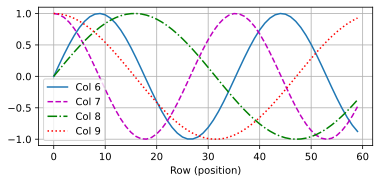

In [22]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()

X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)', 
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

#### 绝对位置信息

In [23]:
for i in range(8):
    print(f'{i}的二进制是：{i:>03b}')

0的二进制是：000
1的二进制是：001
2的二进制是：010
3的二进制是：011
4的二进制是：100
5的二进制是：101
6的二进制是：110
7的二进制是：111


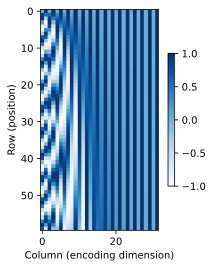

In [24]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

> 在二进制表示中，较高比特位的交替频率低于较低比特位， <br> 
> 与上面的热图所示相似，只是位置编码通过使用三角函数在编码维度上降低频率。 <br>
> 由于输出是浮点数，因此此类连续表示比二进制表示法更节省空间。

#### 相对位置信息

, 再看一遍自注意力的视频

## Transformer

> 与基于Bahdanau注意力实现的序列到序列的学习相比,<br>
> Transformer的编码器和解码器是基于<font color=green>纯自注意力</font>的模块<font color=green>叠加(串行)</font>而成的。用<font color=green>自注意力</font>完全替代了<font color=green>RNN</font><br>
> 源（输入）序列和目标（输出）序列的<font color=green>嵌入（embedding）表示</font>加上<font color=green>位置编码(positional encoding)</font><br>
> 再分别输入到编码器解码器中.


> Transformer块 * n: 编码器解码器的块数相同,都是n个块(num_layers)，为了对称。且是串行的（详见代码）不是并行。 <br>
> 多头注意力, 有两个(<font color=green>编码器的是自注意力</font>，信息传递到解码器的是<font color=green>正常的注意力</font>，kv来自编码器，query来自target序列）， <font color=green>掩蔽多头注意力</font>有一个<font color=green>且是自注意力</font><br>
> 编码器解码器的连线：<font color=green>信息传递</font><br>


![](./imgs/transformer.svg)

### position-wise feed-forward network

* 另外两个浅蓝色的块块

> Transformer模型中基于位置的前馈网络使用同一个多层感知机(<font color=green>就是全连接</font>)，作用是对所有<font color=green>序列位置</font>的表示进行转换。

> 基于位置的前馈网络对序列中的所有位置的表示进行变换时使用的是同一个多层感知机（MLP），这就是称前馈网络为<font color=green>基于位置的(positionwise)的原因。<br>
>> 在下面的实现中，输入$\rm X$的形状（batch_size, 时间步数或序列长度， 隐单元数或特征维度)<br>
>> 将被两层的感知机转换成形状为(batch_size, 时间步数，ffn_num_outputs)的输出张量<br>
    
> 作用: <br>
>> 调整attention输出调整为输入形状,便于num_layers迭代<br>
>>  <font color=green>将输入由形状(b, n,d)变换成(bn, d)</font>, 并作用于两个全连接层。既<font color=green>经过attention后,变为与输入形状一致,以便进入下一个block</font><br>
>> 输出完再换回来， 将输出形状由(bn,d)变回为(b, n, d)<br>
>> 等价于两层kernel_size=1的一维卷积层。（$1\times 1$的卷积等价于全连接层）<br>
    
> 其后紧接全连接层如图所示， 对于输入(b, n, d)， 维度是由问题的。三维无法输入nn.Linear<br>
>> 卷积是将(n,d)变成一个维度，变为(b, (n,d))输入一维的卷积。d就是channel， n就是kernel_size。<br>
    >> 但是seq2seq不行，因为序列长度n是变化的。<font color=green>解决方法是: 对每一个序列中的每一个元素给你作用一个全连接。</font>

In [2]:
import math
import torch
import pandas as pd
import torch.nn as nn
from d2l import torch as d2l

In [3]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__()
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
        
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

> 改变张良的最里层维度的尺寸，会改变positionwise feed-forward network的输出尺寸<br>
> 应为用同一个多层感知机对所有位置上的输入进行变换， 所以当所有这些位置的输入相同时，他们的输出也是相同的。

In [44]:
# 234的进出，后4会变成8 238，这就是FFN的作用
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
out = ffn(torch.ones((2, 3, 4)))
out
out.shape

PositionWiseFFN(
  (dense1): Linear(in_features=4, out_features=4, bias=True)
  (relu): ReLU()
  (dense2): Linear(in_features=4, out_features=8, bias=True)
)

tensor([[[ 0.0426, -0.1959, -0.0497,  0.4614,  0.4166, -0.3703,  0.4820,
          -0.1384],
         [ 0.0426, -0.1959, -0.0497,  0.4614,  0.4166, -0.3703,  0.4820,
          -0.1384],
         [ 0.0426, -0.1959, -0.0497,  0.4614,  0.4166, -0.3703,  0.4820,
          -0.1384]],

        [[ 0.0426, -0.1959, -0.0497,  0.4614,  0.4166, -0.3703,  0.4820,
          -0.1384],
         [ 0.0426, -0.1959, -0.0497,  0.4614,  0.4166, -0.3703,  0.4820,
          -0.1384],
         [ 0.0426, -0.1959, -0.0497,  0.4614,  0.4166, -0.3703,  0.4820,
          -0.1384]]], grad_fn=<AddBackward0>)

torch.Size([2, 3, 8])

### 残差连接和层规范化

> 残差连接residual connection，层规范化都是构建有效的深度架构的关键:<font color=green>至少不会比越过attention直接输入要差(请看图)</font><br>
> 层规范化是基于特征维度进行规范化.<br>
> <font color=green>layer normalization:自然语言处理和 batch normalization:计算机视觉效果好</font><br>
> batch normalization:通道向量或者特征向量做归一化。特征是d中的一维（将其方差变1，均值变0）， 作NLP如果选d[i]的话，输入BN的是（n ， batch_size), n是序列的长度，长度可变，BN会不稳定。<br>
> layer normalization:对每一个样本做归一化。虽然序列还是变，但这里是在一个样本里面归一化了。

> <img src=./imgs/bn_ln.png width=30% /><br>
> b: batch_size d: dimention, len=序列长度<br>
> batch normalization: 在dimension上选一个平面进行归一化<br>
> layer normalization: 是在batch_size上选一个样本进行归一化<br>
> 还可以 group normal 比如：<br>
> <img src=./imgs/group_normal.png width=15% /><br>



> 这里接入batch_normalization 和 layer_normalization<br>




In [6]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2],[2,3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
X

tensor([[1., 2.],
        [2., 3.]])

In [7]:
'layer normal:', ln(X)
'batch normal:', bn(X)

('layer normal:',
 tensor([[-1.0000,  1.0000],
         [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward>))

('batch normal:',
 tensor([[-1.0000, -1.0000],
         [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward>))

> 现在使用**残差连接**和**层规范化**来实现AddNorm类。<br>
> **暂退法dropout**也被作为正则化方法使用。

In [8]:
class AddNorm(nn.Module):
    
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
        
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

> 残差连接要求两个输入的形状相同， 以便加法操作后输出张量的形状相同。

In [9]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

AddNorm(
  (dropout): Dropout(p=0.5, inplace=False)
  (ln): LayerNorm((3, 4), eps=1e-05, elementwise_affine=True)
)

torch.Size([2, 3, 4])

### 信息传递

> - 编码器中的输出$y_1, \cdots, y_n$ 这里的<font color=green>n是num_layer of encoder</font><br>
> - 将其作为解码器中第$i$(无论哪个i都是相同的上下文)个Transformer块中多头注意力的key和value。query来自target序列。类似seq2seq中的Bahdanau注意力<br>
> - 意味着解码器和编码器中<font color=green>块的个数</font>和输出维度都是一样的。

### 预测

> - 预测第<font color=green>$t + 1$</font>个输出时<br>
> - 解码器中输入前$t$个预测值<br>
>> - 在自注意力中，前$t$个预测值作为key和value，<font color=green>第$t$个预测的值**还**作为query, </font>。<br>


> 在做训练的时候：我可以一<font color=green>筐都丢进来并行（当然是masked掩蔽的）, 并行度是O(n)见上面CNN，RNN，Attention对比</font>  在做预测的时候：<font color=green>就是顺序的来。</font>

<img src=./imgs/self_attention.png width=20% />

### 编码器

> 从宏观角度看，Transformer的编码器是由多个相同的层叠加而成的, 每个层都有两个子层（sublayer)<br>
>> 第一个子层是<font color=green>多头自注意力(multi-head self-attention)汇聚</font>；<br>
>> 第二个子层是<font color=green>基于位置的前馈网络(positionwise feed-forward network)</font><br>

> 基本流程:<br>
>> - 在计算编码器的自注意力时，查询，键和值都来自<font color=green>前一个编码器层的输出</font><br>
>> - 受残差网络的启发，每个子层都采用<font color=green>残差链接（residual connection)</font><br>
>> - 在Transformer中，对于序列中任何位置的任何输入$\rm x \in \mathbb{R}^d$,都要求满足$\rm sublayer(x) \in \mathbb{R}^d$, 以便残差链接满足$\rm x + sublayer(x) \in \mathbb{R}^d$<br>
>> - 在残差链接的加法计算之后，紧接着应用<font color=green>层规范化(layer normalization)</font>.<br>
>> - 因此，输入序列对应的每个位置，Transformer编码器都将输出一个$\rm d$维表示向量。<br>

In [12]:
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

> 两个子层：多头注意力 和 基于位置的前馈网络<br>
> 子层之间：残差连接和紧随的层规范化<br>
> Transformer编码器中的任何层都不会改变其输入的形状。<br>

In [13]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

EncoderBlock(
  (attention): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): Linear(in_features=24, out_features=24, bias=False)
    (W_k): Linear(in_features=24, out_features=24, bias=False)
    (W_v): Linear(in_features=24, out_features=24, bias=False)
    (W_o): Linear(in_features=24, out_features=24, bias=False)
  )
  (addnorm1): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
  (ffn): PositionWiseFFN(
    (dense1): Linear(in_features=24, out_features=48, bias=True)
    (relu): ReLU()
    (dense2): Linear(in_features=48, out_features=24, bias=True)
  )
  (addnorm2): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
)

torch.Size([2, 100, 24])

> 下面的Transformer编码器，堆叠了num_layers个EncoderBlock类的实例。<br>
> 由于这里使用的是值范围在[-1, 1]之间的<font color=green>固定位置编码</font>.<br>
> 因此通过学习得到的<font color=green>输入的嵌入表示的值需要先乘以嵌入维度的平方根进行重新缩放</font>，然后再与**位置编码**相加。

In [37]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module('block' + str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))
                                 
    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间
        # 因此嵌入值乘以维度的平方根进行缩放。
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        # n个块是串行的，不是并行
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [17]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()

TransformerEncoder(
  (embedding): Embedding(200, 24)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (blks): Sequential(
    (block0): EncoderBlock(
      (attention): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.5, inplace=False)
        )
        (W_q): Linear(in_features=24, out_features=24, bias=False)
        (W_k): Linear(in_features=24, out_features=24, bias=False)
        (W_v): Linear(in_features=24, out_features=24, bias=False)
        (W_o): Linear(in_features=24, out_features=24, bias=False)
      )
      (addnorm1): AddNorm(
        (dropout): Dropout(p=0.5, inplace=False)
        (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
      )
      (ffn): PositionWiseFFN(
        (dense1): Linear(in_features=24, out_features=48, bias=True)
        (relu): ReLU()
        (dense2): Linear(in_features=48, out_features=24, bias=True)
      )
      (addnorm2): AddNorm(
        (d

In [18]:
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

> Transformer的编码器输出的形状是(batch_size, 时间步数目，num_hiddens)

### 解码器

> 从宏观角度看，Transformer的解码器也是由多个相同的层叠加而成的,并且层中使用了residual conncetion和layer normalization <br>
>> 除了编码器的两个子层之外，解码器还在两个子层之间插入了第三个子层：编码器-解码器注意力(encoder-decoder attention)<br>

> 在<font color=green>编码器-解码器注意力(encoder-decoder attention)</font>中：<br>
>> 查询: 来自前一个**解码器**的输出（类似Bahdanau)<br>
>> 键值：来自整个编码器的输出<br>

> 在解码器的<font color=green>掩码masked多头自注意力</font>中: <br>
>> 查询，键和值都来自上一个**解码器层**的输出。<br>
>> 但是，**解码器**中的每个位置只能考虑位置之前的所有位置。<br>
>> 这种<font color=green>掩蔽(masked)注意力</font>保留了<font color=green>自回归(auto-regressive)属性</font>，<br>
>> 确保预测仅依赖于已生成的输出词元<br>
>> seq2seq在训练阶段，其<font color=green>输出(解码器)</font>的所有位置（时间步）的词元都是已知的；<br>
>> 然后在预测阶段，其输出序列的词元是逐个生成的。因此在任何<font color=green>解码器</font>时间步中，只有生成的词元才能用于<font color=green>解码器的自注意力</font>计算中。<br>
>> 为了保留解码器的自回归属性，其<font color=green>掩蔽(masked)注意力</font>设定了参数dec_valid_lens, <br>
>> 以便任何查询都只会与解码器中所有已经生成词元的位置(即直到该查询位置为止)进行注意力计算


![](./imgs/transformer_decoder.gif)

> 在解码器的DecoderBlock实现中包含了3个层<br>
> <font color=green>掩码masked多头自注意力</font><br>
> "编码器-解码器”注意力层<br>
> 基于位置的前馈网络, position-wise feed-forwad net<br>
> 上述<font color=green>子层</font>也都被残差连接和紧随的层规范化围绕。<br>


![](./imgs/transformer.svg)

In [21]:
class DecoderBlock(nn.Module):
    
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
        
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头: (batch_size, num_steps),
            # 其中每一行[1, 2, ...,num_steps]
            dec_valid_lens = torch.arange(1, num_steps+1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        
        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器-解码器注意力
        # enc_outputs的开头: (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

> 为了便于在 <font color=green>编码器-解码器注意力(encoder-decoder attention)</font>进行缩放点积计算和残差连接中进行加法计算<br>
> 编码器解码器的特征维度都是num_hiddens

In [23]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

DecoderBlock(
  (attention1): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): Linear(in_features=24, out_features=24, bias=False)
    (W_k): Linear(in_features=24, out_features=24, bias=False)
    (W_v): Linear(in_features=24, out_features=24, bias=False)
    (W_o): Linear(in_features=24, out_features=24, bias=False)
  )
  (addnorm1): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
  (attention2): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): Linear(in_features=24, out_features=24, bias=False)
    (W_k): Linear(in_features=24, out_features=24, bias=False)
    (W_v): Linear(in_features=24, out_features=24, bias=False)
    (W_o): Linear(in_features=24, out_features=24, bias=False)
  )
  (addnorm2): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): Lay

torch.Size([2, 100, 24])

> 接下来构建num_layers个DecoderBlock实例组成的完整的Transformer解码器<br>
> 最后通过一个全连接层计算所有vocab_size个可能得输出词元的预测值<br>
> 解码器的自注意力权重和编码器的注意力权重都被存储下来，方便可视化

In [24]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module('block'+str(i), 
                DecoderBlock(key_size, query_size, value_size, num_hiddens, 
                             norm_shape, ffn_num_input, ffn_num_hiddens, 
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None]*len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # “编码器-解码器自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    
    @property
    def attention_weights(self):
        return self._attention_weights

### 训练

> 这里指定编码器解码器都是2层<br>
> 使用4头注意力

loss 0.032, 14881.4 tokens/sec on cuda:0


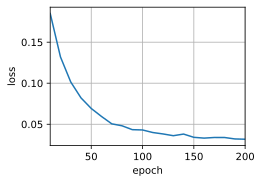

In [25]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [26]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


> 当进行最后一个英语到法语的句子翻译工作时，<br>
> 让我们可视化Transformer的注意力权重<br>
> 编码器自注意力权重的形状为(编码器层数,  注意力头数, num_steps或查询数目, num_steps或”键值对"的数目)
                

In [27]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

> 编码器的自注意力中，查询和键都来自相同的输入序列。<br>
> 因为<font color=green>填充padding词元</font>是不携带信息的，因此通过指定输入序列的有效长度可以避免查询与使用填充词元的位置计算注意力<br>
> 逐行呈现两层多头注意力的权重。每个注意力头都根据查询、键和值的不同的表示子空间来表示不同的注意力

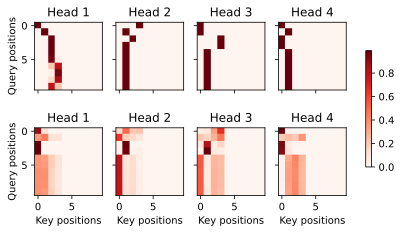

In [28]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

> 为了可视化解码器的自注意力权重和“编码器－解码器”的注意力权重，我们需要完成更多的数据操作工作。<br>
> 例如用零填充被掩蔽住的注意力权重<br>

> 值得注意的是，解码器的自注意力权重和“编码器－解码器”的注意力权重都有相同的查询：<br>
> 即以序列开始词元（<font color=green>beginning-of-sequence,BOS</font>）打头，再与后续输出的词元共同组成序列。

In [30]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

> 由于解码器自注意力的自回归属性，查询不会对当前位置之后的“键－值”对进行注意力计算

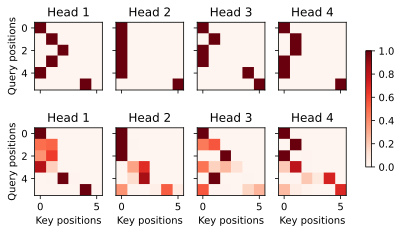

In [32]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

> 与编码器的自注意力的情况类似，通过指定输入序列的有效长度，输出序列的查询不会与输入序列中填充位置的词元进行注意力计算

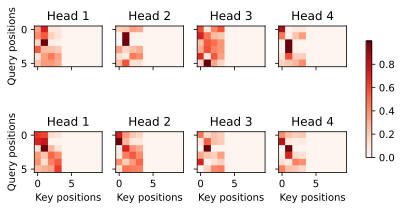

In [34]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))